# CICE6 Standalone Analysis Notebook

In [158]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import datetime
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings
import dask
from dask.distributed import Client
from datetime import timedelta
import glob
import os
from datatree import DataTree, map_over_subtree
import re
import socket
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import matplotlib.colors as mcolors
import calendar

warnings.filterwarnings('ignore')

In [159]:
def get_path(experiments):
    hostname = socket.gethostname()
    if "gadi" in hostname:
        machine = "gadi"
        path = "/g/data/ps29/nd0349/runs/cice6/"
        fig_path = "/home/566/nd0349/access-om3-analysis/figures/"
    elif "setonix" in hostname:
        machine = "setonix"
    else:
        machine = "noahday"
        path = "/Users/noahday/GitHub/cice-dev/cice-dirs/runs/"
        fig_path = "/Users/noahday/GitHub/access-om3-analysis/figures/"

    print(f"Running on {machine}")
        
    return path, fig_path


# experiments = ["baseline-gx3", "wave-constant-gx3", "wave-profile-gx3", "wave-random-gx3"]  
experiments = ["test"]#, "wave-constant-1deg", "wave-profile-1deg", "wave-random-1deg"]  
# machine = "gadi" # "noahday" or "gadi"
# experiments = ["baseline-1deg", "baseline-025deg"]
#["baseline-1deg", "wave-constant-1deg"] 
n_expts = len(experiments)
expt_path, fig_path = get_path(experiments)
histfreq = ["d", "h", "h", "h", "h"] # "d" or "m"

VARS = ["aice", "hi", "wave_sig_ht", "fsdrad", "Tair", "sst", "sss", "uocn", "vocn", "uatm", "vatm"]
keep_vars = ["TLAT", "TLON", "time", "tarea"] + VARS

# Create an empty dictionary to store datasets
datasets = {}

for i, expt in enumerate(experiments):
    path = os.path.join(expt_path, expt, "history/")
    if histfreq[i] == "h":
        file_pattern = os.path.join(path, "iceh_01h.????-??-??-?????.nc")
    elif histfreq[i] == "d":
        file_pattern = os.path.join(path, "iceh.????-??-??.nc")
    elif histfreq[i] == "m":
        file_pattern = os.path.join(path, "iceh.????-??.nc")  # Adjust this if needed
    files = sorted(glob.glob(file_pattern))
    
    if not files:
        print(f"No files found for {expt}, skipping...")
        continue

    sample_ds = xr.open_dataset(files[0])
    drop_vars = [var for var in sample_ds.variables if var not in keep_vars]

    ds = xr.open_mfdataset(
        files, 
        # chunks="auto",
        combine="by_coords", 
        decode_timedelta=False,
        drop_variables=drop_vars
    )

    datasets[expt] = ds  # Store the dataset in the dictionary

dt = DataTree.from_dict({expt: DataTree(data=ds) for expt, ds in datasets.items()})
dt

Running on noahday


DataTree('None', parent=None)
└── DataTree('test')
        Dimensions:      (time: 225, nj: 300, ni: 360)
        Coordinates:
          * time         (time) datetime64[ns] 2005-01-02 2005-01-03 ... 2005-08-14
            TLON         (nj, ni) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
            TLAT         (nj, ni) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
        Dimensions without coordinates: nj, ni
        Data variables:
            tarea        (time, nj, ni) float32 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            hi           (time, nj, ni) float32 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            aice         (time, nj, ni) float32 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            wave_sig_ht  (time, nj, ni) float32 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            fsdrad       (time, nj, ni) float32 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
        Attributes:
            title:               sea ice model output for CICE
            contents:            Diagnostic and Prognostic Variables
            source:              Los Alamos Sea Ice Model, CICE_6.6.0
            comment:             This year has 365 days
            comment2:            File written on model date 20050102
            comment3:            seconds elapsed into model date:      0
            time_period_freq:    day_1
            time_axis_position:  end
            conventions:         CF-1.0
            history:             This dataset was created on 2025-07-16 at 09:47:47.9
            io_flavor:           io_netcdf

In [160]:
def basic_axis(dims):
    # Determine number of rows and columns for subplots
    ncols = dims[1]#int(np.ceil(np.sqrt(number_panels)))
    nrows = dims[0]#int(np.ceil(number_panels / ncols))
    number_panels = ncols*nrows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
        figsize=(4 * ncols, 4 * nrows),  # Adjust figure size
        gridspec_kw={'wspace': 0.1, 'hspace': 0.15}  # Adjust spacing
    )
    
    if number_panels == 1:
        axes = np.array([[axes]])  # Ensure axes is always a 2D array
    elif nrows == 1 or ncols == 1:
        axes = axes.reshape((nrows, ncols))
    
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray', linewidth=0.5)
    
    for ax in axes.flat[:number_panels]:  # Only iterate over required axes
        ax.set_global()
        ax.coastlines(resolution='50m')
        ax.add_feature(land_50m)
        ax.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
    
    # Hide unused subplots if necessary
    for ax in axes.flat[number_panels:]:
        ax.set_visible(False)
    axes = axes.flatten()
    return fig, axes

In [161]:
# hour_abbr = [f"{h:02d}" for h in range(24)]
# print(hour_abbr[time_idx])histfreq  # Example usage
# histfreq
# dt[iGroup].isel(time=time_idx-1).copy()['time'].item()#.strftime("%Y%m%dT%H%M%S")
# expt_path
# path
# dt.groups[1:]

# ds_plot = dt[iGroup].isel(time=time_idx-1).copy().sel(nj=slice(0,50))
# ds_plot['aice'].plot()

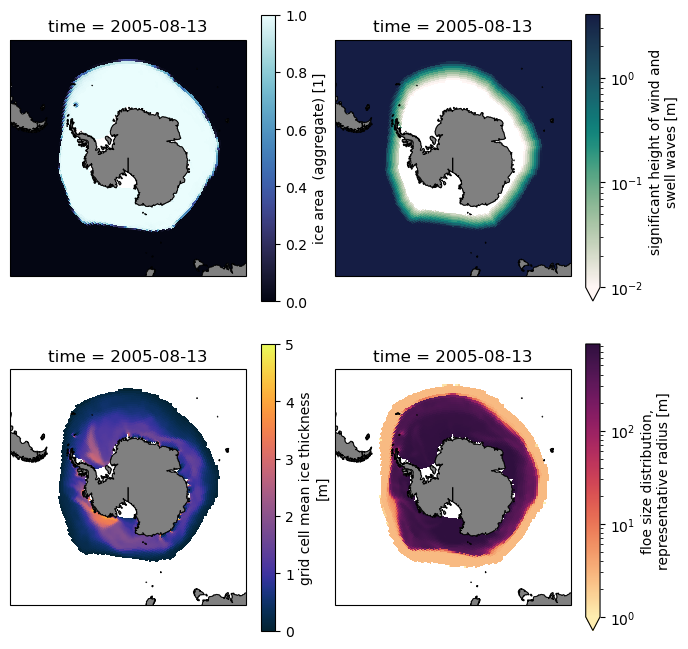

In [165]:
time_idx = -1 # 2 = Feb


for i, iGroup in enumerate(dt.groups[1:]):
    if histfreq[i] == "h":
        time_abbr = "Fix"
        # time_abbr = dt[iGroup].isel(time=time_idx-1).copy()['time'].item().strftime("%Y%m%dT%H%M%S")
        # time_val = dt[iGroup].isel(time=time_idx-1).copy()['time'].item()
        # time_val_dt = pd.to_datetime(time_val)
        # time_abbr = time_val_dt.strftime("%Y%m%dT%H%M%S")
        # time_abbr = calendar.month_abbr[time_idx]
    elif histfreq[i] == "d":
        time_abbr = "Fix"
        # time_abbr = dt[iGroup].isel(time=time_idx-1).copy()['time'].item().strftime("%Y%m%dT%H%M%S")
        # time_val = dt[iGroup].isel(time=time_idx-1).copy()['time'].item()
        # time_val_dt = pd.to_datetime(time_val)
        # time_abbr = time_val_dt.strftime("%Y%m%dT%H%M%S")
        # time_abbr = calendar.month_abbr[time_idx]
    elif histfreq[i] == "m":
        time_abbr = calendar.month_abbr[time_idx]
    fig, axes = basic_axis([2,2])
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy().sel(nj=slice(0,150))
    ds_plot["aice"].plot(ax=axes[0], x="TLON", y="TLAT", vmin=0, vmax=1, cmap=cmo.ice, transform=ccrs.PlateCarree()) 
    ds_plot["wave_sig_ht"].plot(ax=axes[1], x="TLON", y="TLAT", norm=mcolors.LogNorm(vmin=1e-2, vmax=ds_plot["wave_sig_ht"].max().values), cmap=cmo.tempo, transform=ccrs.PlateCarree()) 
    # ds_plot["wave_sig_ht"].plot(ax=axes[1], x="TLON", y="TLAT", vmin=0, vmax=ds_plot["wave_sig_ht"].max().values, cmap=cmo.tempo, transform=ccrs.PlateCarree()) 
    ds_plot["hi"].where(ds_plot["aice"]>0.15).plot(ax=axes[2], x="TLON", y="TLAT", vmin=0, vmax=5, cmap=cmo.thermal, transform=ccrs.PlateCarree()) 
    ds_plot["fsdrad"].plot(ax=axes[3], x="TLON", y="TLAT", cmap=cmo.matter, 
                                            norm=mcolors.LogNorm(vmin=1, vmax=ds_plot["fsdrad"].max().values), transform=ccrs.PlateCarree()) 
    # plt.suptitle(f"{iGroup[1:]}")
    plt.savefig(os.path.join(fig_path, f"aice_swh_hi_fsdrad_{iGroup[1:]}.png"), dpi=300, bbox_inches="tight") 


    

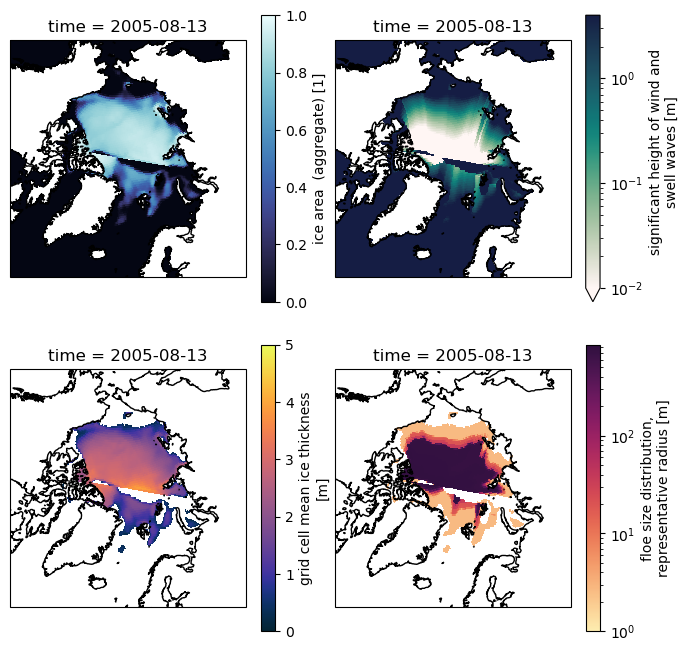

In [166]:
time_idx = -1  # 2 = Feb

for i, iGroup in enumerate(dt.groups[1:]):
    fig, axes = plt.subplots(
        nrows=2, ncols=2,
        subplot_kw={'projection': ccrs.NorthPolarStereo(true_scale_latitude=70)},
        figsize=(8, 8),  # 4 * 2 by 4 * 2
        gridspec_kw={'wspace': 0.1, 'hspace': 0.15}
    )

    land_50m = cft.NaturalEarthFeature(
        'physical', 'land', '50m',
        edgecolor='black', facecolor='gray', linewidth=0.5
    )

    # Flatten and iterate over only the first 4 axes
    for ax in axes.flat[:4]:
        ax.set_global()
        ax.coastlines(resolution='50m')
        # ax.add_feature(land_50m)
        ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

    # Extract relevant dataset slice
    ds_plot = dt[iGroup].isel(time=time_idx - 1).copy()

    # Plotting
    ds_plot["aice"].plot(
        ax=axes[0, 0], x="TLON", y="TLAT", vmin=0, vmax=1,
        cmap=cmo.ice, transform=ccrs.PlateCarree(), add_colorbar=True
    )

    ds_plot["wave_sig_ht"].plot(
        ax=axes[0, 1], x="TLON", y="TLAT",
        norm=mcolors.LogNorm(vmin=1e-2, vmax=ds_plot["wave_sig_ht"].max().values),
        cmap=cmo.tempo, transform=ccrs.PlateCarree(), add_colorbar=True
    )

    ds_plot["hi"].where(ds_plot["aice"] > 0.15).plot(
        ax=axes[1, 0], x="TLON", y="TLAT",
        vmin=0, vmax=5, cmap=cmo.thermal, transform=ccrs.PlateCarree(), add_colorbar=True
    )

    ds_plot["fsdrad"].where(ds_plot["aice"] > 0.15).plot(
        ax=axes[1, 1], x="TLON", y="TLAT",
        cmap=cmo.matter,
        norm=mcolors.LogNorm(vmin=1, vmax=ds_plot["fsdrad"].max().values),
        transform=ccrs.PlateCarree(), add_colorbar=True
    )

    # Optional: add your own colorbars manually for better layout control
    # fig.colorbar(...)

    # plt.suptitle(f"{iGroup[1:]}")
    fig.savefig(
        os.path.join(fig_path, f"aice_swh_hi_fsdrad_NH_{iGroup[1:]}.png"),
        dpi=300, bbox_inches="tight"
    )

In [164]:
ds_plot["wave_sig_ht"].max().values 

array(3.9907503, dtype=float32)

KeyError: 'Could not find node at Tair'

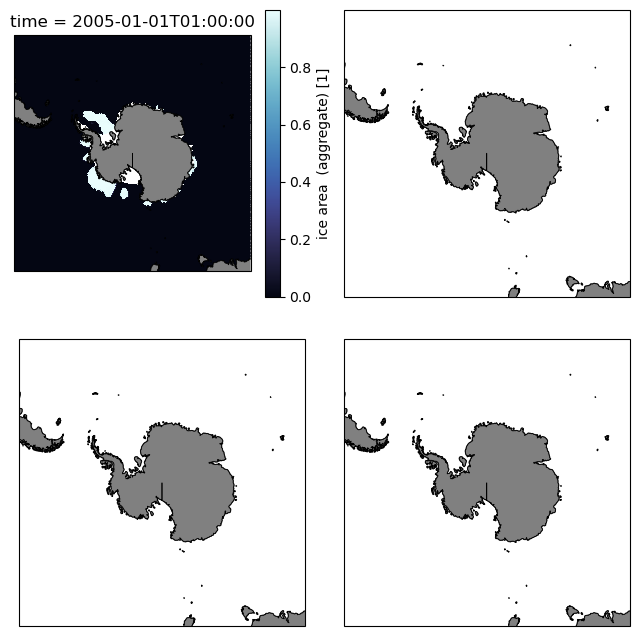

In [44]:
time_idx = 1 # 2 = Feb

for i, iGroup in enumerate(dt.groups[1:]):
    # if histfreq[i] == "h":
    #     time_abbr = pd.Timestamp(dt[iGroup].isel(time=time_idx-1).copy()['time'].item()).strftime("%Y%m%dT%H%M%S")
    # elif histfreq[i] == "d":
    #     time_abbr = dt[iGroup].isel(time=time_idx-1).copy()['time'].item().strftime("%Y%m%dT%H%M%S")
    # elif histfreq[i] == "m":
    #     time_abbr = calendar.month_abbr[time_idx]
    fig, axes = basic_axis([2,2])
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy()
    ds_plot["aice"].plot(ax=axes[0], x="TLON", y="TLAT", cmap=cmo.ice, transform=ccrs.PlateCarree()) 
    ds_plot["Tair"].plot(ax=axes[1], x="TLON", y="TLAT", cmap=cmo.thermal, transform=ccrs.PlateCarree()) 
    ds_plot["uatm"].plot(ax=axes[2], x="TLON", y="TLAT", cmap=cmo.balance, transform=ccrs.PlateCarree()) 
    ds_plot["vatm"].plot(ax=axes[3], x="TLON", y="TLAT", cmap=cmo.balance, transform=ccrs.PlateCarree()) 
    
    plt.savefig(fig_path + f"/aice_Tair_sst_sss_{iGroup[1:]}_{time_idx}.png", dpi=300, bbox_inches="tight") 

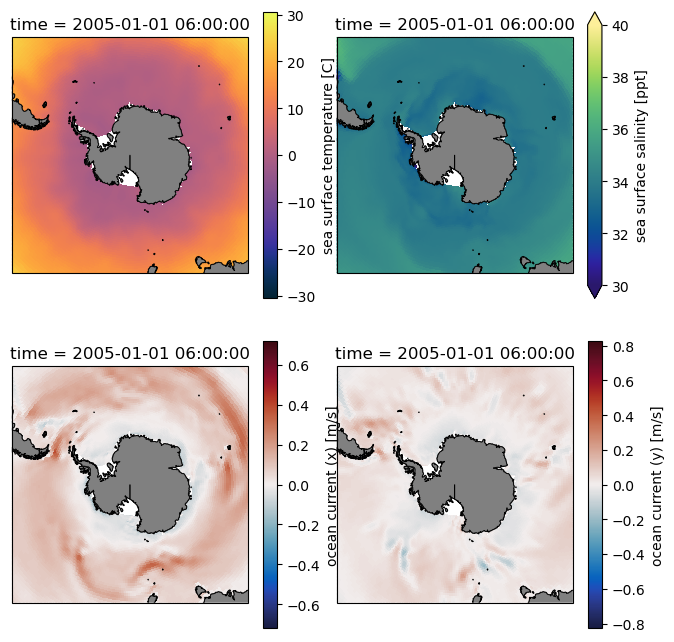

In [88]:
time_idx = 6 # 2 = Feb

for i, iGroup in enumerate(dt.groups[1:]):
    # if histfreq[i] == "h":
    #     time_abbr = pd.Timestamp(dt[iGroup].isel(time=time_idx-1).copy()['time'].item()).strftime("%Y%m%dT%H%M%S")
    # elif histfreq[i] == "d":
    #     time_abbr = dt[iGroup].isel(time=time_idx-1).copy()['time'].item().strftime("%Y%m%dT%H%M%S")
    # elif histfreq[i] == "m":
    #     time_abbr = calendar.month_abbr[time_idx]
    fig, axes = basic_axis([2,2])
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy()
    ds_plot["sst"].plot(ax=axes[0], x="TLON", y="TLAT", cmap=cmo.thermal, transform=ccrs.PlateCarree()) 
    ds_plot["sss"].plot(ax=axes[1], x="TLON", y="TLAT", cmap=cmo.haline, transform=ccrs.PlateCarree(), vmin=30, vmax=40) 
    ds_plot["uocn"].plot(ax=axes[2], x="TLON", y="TLAT", cmap=cmo.balance, transform=ccrs.PlateCarree()) 
    ds_plot["vocn"].plot(ax=axes[3], x="TLON", y="TLAT", cmap=cmo.balance, transform=ccrs.PlateCarree()) 
    
    plt.savefig(fig_path + f"/ocn_{iGroup[1:]}_{time_idx}.png", dpi=300, bbox_inches="tight") 

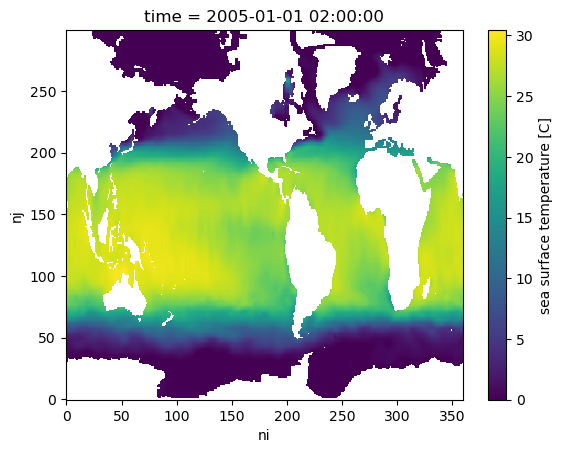

In [68]:
ds_plot['sst'].plot()

### Compare two runs

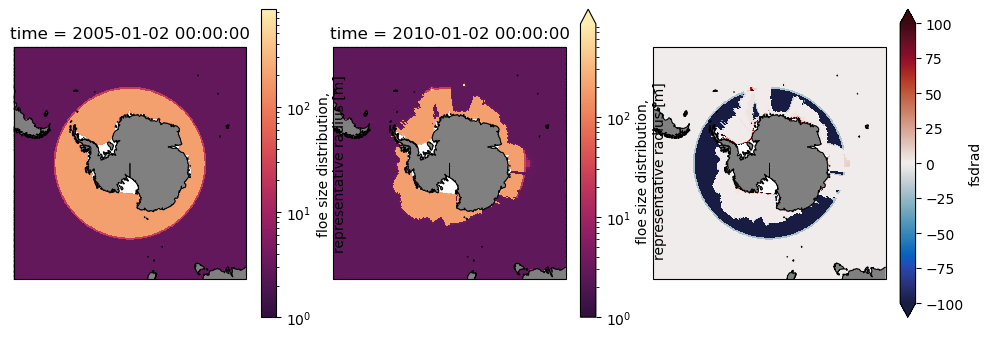

In [100]:
time_idx = 0

fig, axes = basic_axis([1,3])

ds_plot1 = dt[dt.groups[1]].isel(time=time_idx-1).copy()
ds_plot1["fsdrad"].where(ds_plot1["aice"]>0.15).plot(ax=axes[0], x="TLON", y="TLAT", cmap=cmo.matter_r, 
                                        norm=mcolors.LogNorm(vmin=1, vmax=850), transform=ccrs.PlateCarree()) 

ds_plot2 = dt[dt.groups[2]].isel(time=time_idx-1).copy()
ds_plot2["fsdrad"].where(ds_plot2["aice"]>0.15).plot(ax=axes[1], x="TLON", y="TLAT", cmap=cmo.matter_r, 
                                        norm=mcolors.LogNorm(vmin=1, vmax=850), transform=ccrs.PlateCarree()) 

difference = (ds_plot2["fsdrad"].where(ds_plot2["aice"]>0.15) - ds_plot1["fsdrad"].where(ds_plot1["aice"]>0.15))
difference.plot(ax=axes[2], x="TLON", y="TLAT", cmap=cmo.balance,
                vmin=-100, vmax=100 , transform=ccrs.PlateCarree()) 

## Make a quick movie 🎬

In [17]:
from io import BytesIO
# import xarray as xr
import matplotlib

matplotlib.use("Agg")
import imageio.v3 as iio


def fancier_plot(ds_sel, time, var, hemisphere="south"):
    if hemisphere == "south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        lat_limits = [-90, -45]
    elif hemisphere == "north":
        projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
        lat_limits = [45, 90]
    else:
        raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")


    fig, ax = plt.subplots(
                         subplot_kw={'projection': projection},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

    # Add coastlines and land features
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                       edgecolor='black',
                                       facecolor='gray', linewidth=0.5)

    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

    plot_settings = {
        "aice": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},  # Ice concentration (0 to 1)
        "fsdrad": {"cmap": cmo.thermal, "vmin": 0, "vmax": 850},  # Floe size distribution radius (m)
        "hi": {"cmap": cmo.deep, "vmin": 0, "vmax": 5},  # Sea ice thickness (m)
        "hs": {"cmap": cmo.amp, "vmin": 0, "vmax": 0.5},  # Snow depth on sea ice (m)
        "hfs": {"cmap": cmo.amp, "vmin": 0, "vmax": 1},  # Snow thickness on refrozen leads (m)
        "tice": {"cmap": cmo.balance, "vmin": -30, "vmax": 0},  # Ice temperature (°C)
        "uvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ice velocity (zonal, m/s)
        "vvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ice velocity (meridional, m/s)
        "strength": {"cmap": cmo.matter, "vmin": 0, "vmax": 50e3},  # Ice strength (N/m)
        "divu": {"cmap": cmo.curl, "vmin": -1e-5, "vmax": 1e-5},  # Divergence (1/s)
        "shear": {"cmap": cmo.curl, "vmin": 0, "vmax": 1e-5},  # Shear strain rate (1/s)
        "uocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ocean current (zonal, m/s)
        "vocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ocean current (meridional, m/s)
        "wave_sig_ht": {"cmap": cmo.tempo, "vmin": 0, "vmax": 10},  # Significant wave height (m)
    }

    # Get the settings for the selected variable, defaulting to None if not found
    settings = plot_settings.get(var, {})

    # Apply the settings in the plot call
    ds_sel[var].plot(
        ax=ax,
        x="TLON",
        y="TLAT",
        cmap=settings.get("cmap"),
        vmin=settings.get("vmin"),
        vmax=settings.get("vmax"),
        transform=ccrs.PlateCarree(),
    )
    with BytesIO() as buf:
        fig.savefig(buf, format="png")
        plt.close(fig)
        image = iio.imread(buf.getvalue())
    return image



In [9]:
client = Client(threads_per_worker=1, memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50069/status,
Dashboard: http://127.0.0.1:50069/status,Workers: 8
Total threads: 8,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50070,Workers: 8
Dashboard: http://127.0.0.1:50069/status,Total threads: 8
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50092,Total threads: 1
Dashboard: http://127.0.0.1:50099/status,Memory: 0 B
Nanny: tcp://127.0.0.1:50073,


In [12]:
%%time
import calendar
month = 2

model_name = 'cice6'
var = "aice"
hemisphere = "south"

for i, iGroup in enumerate(dt.groups[1:]):
    ds = dt[iGroup].copy()
    expt_name = iGroup[1:]
    ice_mask = (ds.aice > 0.15).compute()
    southern_ocean_mask = (ds.TLAT < -50).compute()
    combined_mask = ((ds.aice > 0.15) & (ds.TLAT < -50)).compute() # Mask not working
    ds_tmp = ds.where(southern_ocean_mask, drop=True).copy()
    ds_tmp = ds.chunk({"time": 1, "ni": -1, "nj": -1})

    futures = [
        client.submit(fancier_plot, ds_tmp.sel(time=time), time, var, hemisphere) for time in ds_tmp["time"].values
    ]

    with iio.imopen(f"figures/{var}_{model_name}_{expt_name}_{hemisphere}.gif", "w", extension=".gif") as f:
        for future in futures:
            image = future.result()
            f.write(image)



CPU times: user 21 s, sys: 1.82 s, total: 22.8 s
Wall time: 35.9 s


In [ ]:


# ds_tmp['fsdrad'].where(ice_mask, drop=True).isel(time=0).plot()

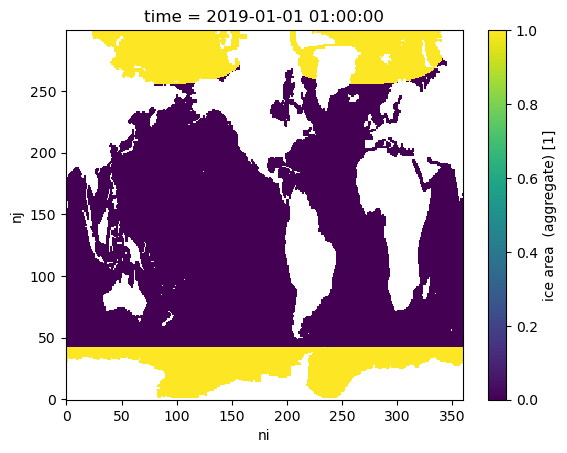

In [20]:
%matplotlib inline
ds_tmp['aice'].isel(time=0).plot()
plt.show()

In [10]:
# @map_over_subtree
# def sea_ice_area_model(ds, hemisphere="south"):
#     # print(ds.yt_ocean)
#     # sic = ds.aice_m.cf.sel(Y=slice(-90, 0))
    
#     if hemisphere == "south":
#         sic = ds.aice.sel(nj=slice(0,ds.nj.size//2))
#         variable_name = "si_area_south"
#     else:
#         sic = ds.aice.isel(nj=slice(ds.nj.size//2,ds.nj.size))
#         variable_name = "si_area_north"

#     print(type(sic))
    
#     # if isinstance(sic, DataTree):
#     #     print("sic is a DataTree object")
#     # else:
#     #     print("sic is NOT a DataTree object")
        
#     area_km2 = ds.tarea / 1e6
#     return sea_ice_area_model(sic, area_km2).to_dataset(name=variable_name).load()

In [52]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_area_model(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

def sea_ice_extent(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_extent_model(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

In [53]:
@map_over_subtree
def calculate_SIA_SIE_model(ds):
    # Compute for Southern Hemisphere
    sic_south = ds.aice.where(ds.TLAT < 0)
    area_south_km2 = ds.tarea.where(ds.TLAT < 0) / 1e6
    si_area_south = sea_ice_area_model(sic_south, area_south_km2).to_dataset(name="si_area_south")
    si_extent_south = sea_ice_extent_model(sic_south, area_south_km2).to_dataset(name="si_extent_south")

    # Compute for Northern Hemisphere
    sic_north = ds.aice.where(ds.TLAT > 0)
    area_north_km2 = ds.tarea.where(ds.TLAT > 0) / 1e6
    si_area_north = sea_ice_area_model(sic_north, area_north_km2).to_dataset(name="si_area_north")
    si_extent_north = sea_ice_extent_model(sic_north, area_north_km2).to_dataset(name="si_extent_north")

    # Merge both hemispheres into a single dataset
    return xr.merge([si_area_south, si_extent_south, si_area_north, si_extent_north]).load()

In [54]:
model_SIA_SIE_dt = calculate_SIA_SIE_model(dt)
model_SIA_SIE_dt

DataTree('None', parent=None)
├── DataTree('baseline-1deg')
│       Dimensions:          (time: 11)
│       Coordinates:
│         * time             (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
│       Data variables:
│           si_area_south    (time) float32 1.158e+07 6.51e+06 ... 1.934e+07 1.479e+07
│           si_extent_south  (time) float32 1.654e+07 1.082e+07 ... 2.23e+07 1.809e+07
│           si_area_north    (time) float32 1.669e+07 1.833e+07 ... 6.931e+06 1.096e+07
│           si_extent_north  (time) float32 1.784e+07 1.909e+07 ... 8.766e+06 1.246e+07
├── DataTree('wave-constant-1deg')
│       Dimensions:          (time: 11)
│       Coordinates:
│         * time             (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
│       Data variables:
│           si_area_south    (time) float32 1.158e+07 6.51e+06 ... 1.934e+07 1.479e+07
│           si_extent_south  (time) float32 1.654e+07 1.082e+07 ... 2.23e+07 1.809e+07
│           si_area_north    (time) float32 1.669e+07 1.833e+07 ... 6.931e+06 1.096e+07
│           si_extent_north  (time) float32 1.784e+07 1.909e+07 ... 8.766e+06 1.246e+07
├── DataTree('wave-profile-1deg')
│       Dimensions:          (time: 11)
│       Coordinates:
│         * time             (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
│       Data variables:
│           si_area_south    (time) float32 1.158e+07 6.51e+06 ... 1.934e+07 1.479e+07
│           si_extent_south  (time) float32 1.654e+07 1.082e+07 ... 2.23e+07 1.809e+07
│           si_area_north    (time) float32 1.669e+07 1.833e+07 ... 6.931e+06 1.096e+07
│           si_extent_north  (time) float32 1.784e+07 1.909e+07 ... 8.766e+06 1.246e+07
└── DataTree('wave-random-1deg')
        Dimensions:          (time: 11)
        Coordinates:
          * time             (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
        Data variables:
            si_area_south    (time) float32 1.158e+07 6.51e+06 ... 1.934e+07 1.479e+07
            si_extent_south  (time) float32 1.654e+07 1.082e+07 ... 2.23e+07 1.809e+07
            si_area_north    (time) float32 1.669e+07 1.833e+07 ... 6.931e+06 1.096e+07
            si_extent_north  (time) float32 1.784e+07 1.909e+07 ... 8.766e+06 1.246e+07

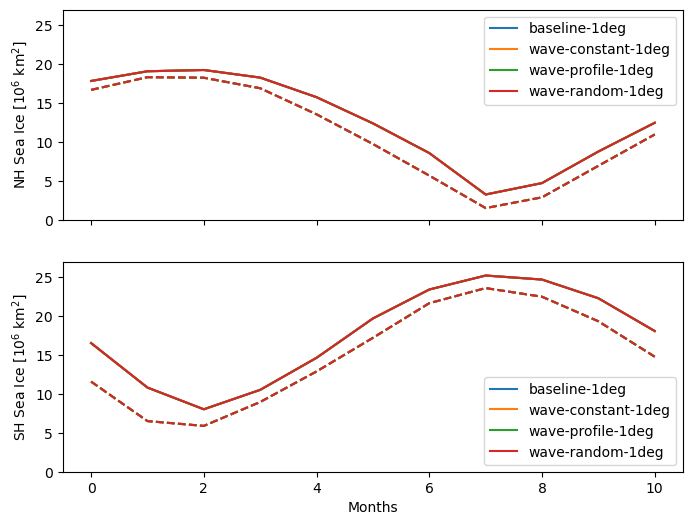

In [55]:
%matplotlib inline

import seaborn as sns
cmap = sns.color_palette(n_colors=6)


fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

for i, iGroup in enumerate(model_SIA_SIE_dt.groups[1:]):
    # Top panel: Northern Hemisphere
    axes[0].plot(model_SIA_SIE_dt[iGroup]['si_extent_north'] * 1e-6, label=iGroup[1:], color=cmap[i])
    axes[0].plot(model_SIA_SIE_dt[iGroup]['si_area_north'] * 1e-6, linestyle='--', label='_nolegend_', color=cmap[i])
    axes[0].set_ylabel("NH Sea Ice [$10^6$ km$^2$]")


    # Bottom panel: Southern Hemisphere
    axes[1].plot(model_SIA_SIE_dt[iGroup]['si_extent_south'] * 1e-6, label=iGroup[1:], color=cmap[i])
    axes[1].plot(model_SIA_SIE_dt[iGroup]['si_area_south'] * 1e-6, linestyle='--', color=cmap[i], label='_nolegend_')
    axes[1].set_ylabel("SH Sea Ice [$10^6$ km$^2$]")
    axes[1].set_xlabel("Months")


for ax in axes:
    ax.set_ylim([0,27])
    ax.legend()

plt.savefig(f"figures/sie_{expt}.png", dpi=300, bbox_inches="tight") 
plt.show()

### Evolution of SIA-weighted variables

In [56]:
def sea_ice_area_weighted_average_model(data, sic, area, range=[0.15, 1]):
    mask = (sic >= range[0]) & (sic <= range[1])
    normalised_area = area.where(mask) / area.where(mask).sum(dim=["ni", "nj"])

    # Ensure normalised_area is properly computed before printing
    if False:
        max_value = normalised_area.max().compute()  # Use .compute() if using Dask
        total_sum = normalised_area.sum().compute()  # Should be ~1.0
    
        print(max_value.values)
        print(total_sum.values)

    return (data * normalised_area).where(mask).sum(dim=["ni", "nj"])

In [57]:
@map_over_subtree
def calculate_sea_ice_average_model(ds, var):
    # Compute for Southern Hemisphere
    data_south = ds[var].where(ds.TLAT < 0)
    aice_south = ds.aice.where(ds.TLAT < 0)
    area_south_km2 = ds.tarea.where(ds.TLAT < 0)
    si_ave_south = sea_ice_area_weighted_average_model(data_south, aice_south, area_south_km2).to_dataset(name="si_ave_south")
    

    # Compute for Northern Hemisphere
    data_north = ds[var].where(ds.TLAT > 0)
    aice_north = ds.aice.where(ds.TLAT > 0)
    area_north_km2 = ds.tarea.where(ds.TLAT > 0)
    si_ave_north = sea_ice_area_weighted_average_model(data_north, aice_north, area_north_km2).to_dataset(name="si_ave_north")

    # Merge both hemispheres into a single dataset
    return xr.merge([si_ave_south, si_ave_north]).load()

In [58]:
var = "fsdrad"
model_average_dt = calculate_sea_ice_average_model(dt, var)
model_average_dt

DataTree('None', parent=None)
├── DataTree('baseline-1deg')
│       Dimensions:       (time: 11)
│       Coordinates:
│         * time          (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
│       Data variables:
│           si_ave_south  (time) float32 23.53 34.3 115.9 174.8 ... 105.0 112.2 128.8
│           si_ave_north  (time) float32 311.9 410.8 452.9 479.0 ... 791.1 761.7 676.2
├── DataTree('wave-constant-1deg')
│       Dimensions:       (time: 11)
│       Coordinates:
│         * time          (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
│       Data variables:
│           si_ave_south  (time) float32 23.53 34.3 115.9 174.8 ... 105.0 112.2 128.8
│           si_ave_north  (time) float32 311.9 410.8 452.9 479.0 ... 791.1 761.7 676.2
├── DataTree('wave-profile-1deg')
│       Dimensions:       (time: 11)
│       Coordinates:
│         * time          (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
│       Data variables:
│           si_ave_south  (time) float32 23.53 34.3 115.9 174.8 ... 105.0 112.2 128.8
│           si_ave_north  (time) float32 311.9 410.8 452.9 479.0 ... 791.1 761.7 676.2
└── DataTree('wave-random-1deg')
        Dimensions:       (time: 11)
        Coordinates:
          * time          (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
        Data variables:
            si_ave_south  (time) float32 23.53 34.3 115.9 174.8 ... 105.0 112.2 128.8
            si_ave_north  (time) float32 311.9 410.8 452.9 479.0 ... 791.1 761.7 676.2

/baseline-1deg
/wave-constant-1deg
/wave-profile-1deg
/wave-random-1deg


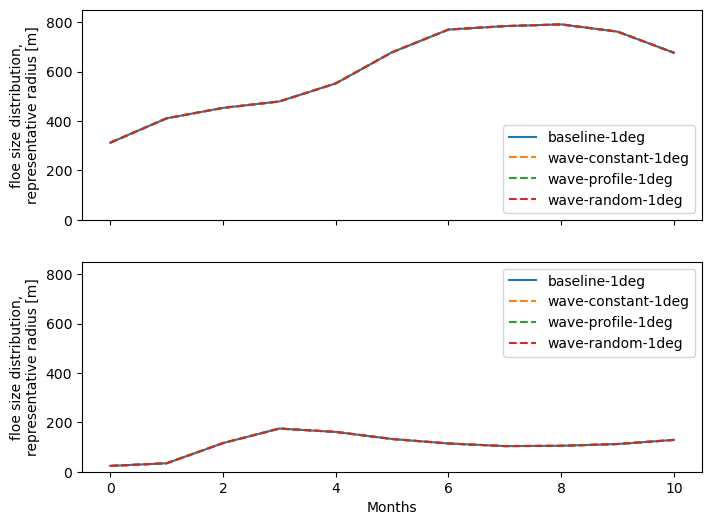

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
cmap = sns.color_palette(n_colors=6)

# Initialize lists to store previous lines for comparison
previous_lines_north = []
previous_lines_south = []

fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

for i, iGroup in enumerate(model_average_dt.groups[1:]):
    print(iGroup)
    # Get data
    si_ave_north = model_average_dt[iGroup]['si_ave_north']
    si_ave_south = model_average_dt[iGroup]['si_ave_south']
    
    # Check overlap with previous lines
    linestyle_north = "--" if any(np.allclose(si_ave_north, prev, atol=0.01) for prev in previous_lines_north) else "-"
    linestyle_south = "--" if any(np.allclose(si_ave_south, prev, atol=0.01) for prev in previous_lines_south) else "-"

    # Top panel: Northern Hemisphere
    axes[0].plot(si_ave_north, label=iGroup[1:], color=cmap[i], linestyle=linestyle_north)
    previous_lines_north.append(si_ave_north)  # Store for future comparison

    # Bottom panel: Southern Hemisphere
    axes[1].plot(si_ave_south, label=iGroup[1:], color=cmap[i], linestyle=linestyle_south)
    previous_lines_south.append(si_ave_south)  # Store for future comparison

    axes[1].set_xlabel("Months")

    long_name = dt[iGroup][var].long_name
    units = dt[iGroup][var].units
    wrapped_name = "\n".join(textwrap.wrap(long_name, width=30))  
    axes[0].set_ylabel(f"{wrapped_name} [{units}]")
    axes[1].set_ylabel(f"{wrapped_name} [{units}]")

for ax in axes:
    ax.set_ylim([0, dt[iGroup][var].max().values])
    ax.legend()

plt.savefig(f"figures/ts_sea_ice_average_{expt}_{var}.png", dpi=300, bbox_inches="tight") 
plt.show()

# Runtime analysis

In [102]:
for Expt in experiments:
    dates = model_average_dt[Expt].time
    start_date = dates[0]
    end_date = dates[-1]
    date_difference = end_date - start_date
    days = date_difference.values.astype('timedelta64[D]') + 1
    
    expt_dir = os.path.join(expt_path, Expt)
    
    # Find all cice.runlog.* files in the experiment directory, sorted by modification time (newest first)
    log_files = sorted(glob.glob(os.path.join(expt_dir, "cice.runlog.*")), key=os.path.getmtime, reverse=True)

    if not log_files:
        print(f"{Expt}: No log files found")
        continue

    total_time = None

    # Try reading log files in order of newest to oldest
    for log_file in log_files:
        with open(log_file, "r") as file:
            log_text = file.read()

        match = re.search(r"Total\s+([\d.]+)\s+seconds", log_text)
        if match:
            total_time = float(match.group(1))
            print(f"{Expt}: Walltime: {np.round(total_time/60)} minutes [{np.round(total_time/60/days.astype('int'),3)} min per model day] ({log_file})")
            break  # Stop once a valid time is found
    
    if total_time is None:
        print(f"{Expt}: Total time not found in any log file")

baseline-1deg: Walltime: 1.0 minutes [0.002 min per model day] (/Users/noahday/GitHub/cice-dev/cice-dirs/runs/baseline-1deg/cice.runlog.250429-161248)
wave-constant-1deg: Walltime: 21.0 minutes [0.07 min per model day] (/Users/noahday/GitHub/cice-dev/cice-dirs/runs/wave-constant-1deg/cice.runlog.250331-110026)
wave-profile-1deg: Walltime: 1.0 minutes [0.002 min per model day] (/Users/noahday/GitHub/cice-dev/cice-dirs/runs/wave-profile-1deg/cice.runlog.250429-155420)
wave-random-1deg: Walltime: 681.0 minutes [2.24 min per model day] (/Users/noahday/GitHub/cice-dev/cice-dirs/runs/wave-random-1deg/cice.runlog.250328-120053)


In [95]:
dates

<xarray.DataArray 'time' (time: 11)>
array(['2005-02-01T00:00:00.000000000', '2005-03-01T00:00:00.000000000',
       '2005-04-01T00:00:00.000000000', '2005-05-01T00:00:00.000000000',
       '2005-06-01T00:00:00.000000000', '2005-07-01T00:00:00.000000000',
       '2005-08-01T00:00:00.000000000', '2005-09-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2005-11-01T00:00:00.000000000',
       '2005-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
Attributes:
    long_name:  time
    bounds:     time_bounds